# **FINAL PROJECT**
## The Great Coastal Gale of 2007

Flora Walchenbach <br>
AOS 573 <br>
Hannah Zanowski <br>
13 December 2023 <br>

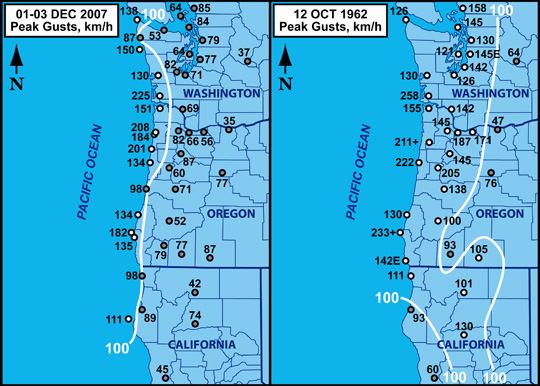 <br>
(From the office of the Washington State Climatologist)

The Great Coastal Gale of 2007 was a series of three storms that tore throught the Pacific Northwest between December 1st and 3rd. The event was responsible for 8 deaths and damages in excess of $1 billion. Flooding, hurricane-force winds, 
avalanches, mudslides, beach erosion, the loss of five marine buoys, and more resulted from the storms' passage. Fallen trees and powerlines made recovery afterward difficult, blocking emergency vehicles and access to resources. At the time, 
I was a kid living in Westport, WA. I remember the ocean flooding halfway up our street and a power outage that lasted for the better part of a week. My parents were stressed half to death, but I was having a great time - this is one of the
things that got me into weather at a young age!

In [261]:
# importing necessary packages
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import metpy.plots as mplots
from metpy.units import units

In [262]:
# read in ERA5 file as an xarray dataset
path = 'coastal_gale_era5'
ds = xr.open_dataset(path,engine='netcdf4')
ds

<xarray.Dataset>
Dimensions:    (longitude: 41, latitude: 41, time: 72)
Coordinates:
  * longitude  (longitude) float32 -130.0 -129.8 -129.5 ... -120.5 -120.2 -120.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 40.5 40.25 40.0
  * time       (time) datetime64[ns] 2007-12-01 ... 2007-12-03T23:00:00
Data variables: (12/14)
    u100       (time, latitude, longitude) float32 ...
    v100       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    ...         ...
    hmax       (time, latitude, longitude) float32 ...
    mdts       (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    swh        (time, latitude, longitude) float32 ...
    tcrw       (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-03 18:36:19 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

###
### What are the long names of these variables? What are the units? 

In [263]:
for i in range(len(list(ds.keys()))):
    key = list(ds.keys())[i]
    print(key,':', ds[key].attrs['long_name'], ', ', ds[key].attrs['units'], '\n')


u100 : 100 metre U wind component ,  m s**-1 

v100 : 100 metre V wind component ,  m s**-1 

u10 : 10 metre U wind component ,  m s**-1 

v10 : 10 metre V wind component ,  m s**-1 

d2m : 2 metre dewpoint temperature ,  K 

t2m : 2 metre temperature ,  K 

i10fg : Instantaneous 10 metre wind gust ,  m s**-1 

lsrr : Large scale rain rate ,  kg m**-2 s**-1 

hmax : Maximum individual wave height ,  m 

mdts : Mean direction of total swell ,  degrees 

msl : Mean sea level pressure ,  Pa 

swh : Significant height of combined wind waves and swell ,  m 

tcrw : Total column rain water ,  kg m**-2 

tp : Total precipitation ,  m 



### What time period does this data cover?

In [264]:
print('Three day\'s worth of data:', ds.time[0].values, 'through', ds.time[-1].values)

Three day's worth of data: 2007-12-01T00:00:00.000000000 through 2007-12-03T23:00:00.000000000


### Alright! Now that we know what our data looks like we can do some investigation.
I would like to know when and where peak wind gusts occured in this dataset, as well as what the winds were like in my hometown of Westport, Washington.

In [265]:
#add wind speed to dataset
ds['wspd'] = np.sqrt(ds.u10**2 + ds.v10**2)
ds.wspd.attrs['units']='m'
ds.wspd.attrs['long_name']='10 meter wind speed'

# calculate maximum winds and gusts
max_10m_wind = ds.wspd.max().values
max_gust = ds.i10fg.max().values

# where did these peak speeds happen?
gust_where = ds.where(ds.i10fg==max_gust, drop=True)
wspd_where = ds.where(ds.wspd==max_10m_wind, drop=True)
g_time, g_lat, g_lon = gust_where.time[0].values, gust_where.latitude[0].values, gust_where.longitude[0].values
w_time, w_lat, w_lon = wspd_where.time[0].values, wspd_where.latitude[0].values, wspd_where.longitude[0].values


# let's put this in km/hr using metpy: 
max_gust = max_gust * units.meters/units.second
max_10m_wind = max_10m_wind * units.meters/units.second

max_gust = max_gust.to(units.kilometers/units.hour)
max_10m_wind = max_10m_wind.to(units.kilometers/units.hour)


print('Maximum gust:', max_gust, '. Occurs at', g_time, ', at lat/lon: ' ,g_lat, ',', g_lon)
print('Maximum 10m wind speed:', max_10m_wind, '. Occurs at', w_time, ', at lat/lon: ' ,w_lat, ',', w_lon)


Maximum gust: 158.65587158203124 kilometer / hour . Occurs at 2007-12-03T10:00:00.000000000 , at lat/lon:  46.5 , -123.75
Maximum 10m wind speed: 96.9769432067871 kilometer / hour . Occurs at 2007-12-02T19:00:00.000000000 , at lat/lon:  43.75 , -124.75


### Dang! That's fast.
Let's plot where those occured:

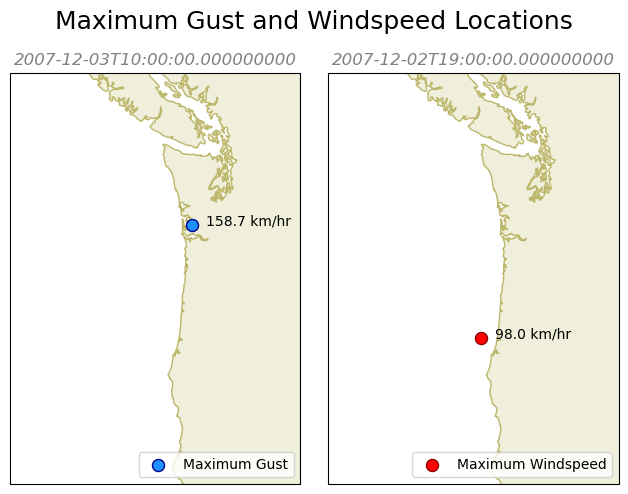

In [266]:
latmin, latmax, lonmin, lonmax = ds.longitude.min(), ds.longitude.max(), ds.latitude.min(), ds.latitude.max()

gs=gridspec.GridSpec(nrows=1,ncols=2)
fig = plt.figure()
ax1=fig.add_subplot(gs[0,0], projection=ccrs.Mercator()) 
ax2=fig.add_subplot(gs[0,1], projection=ccrs.Mercator())
fig.suptitle('Maximum Gust and Windspeed Locations', fontsize=18, y=1.02)

ax1.set_extent([latmin, latmax, lonmin, lonmax], crs=ccrs.PlateCarree())
ax1.coastlines(color='darkkhaki', zorder=1)
ax1.set_title(g_time, color='grey', style='italic')
ax1.add_feature(cfeature.LAND)
ax1.scatter(g_lon, g_lat, marker='.', c='dodgerblue', s=300, label='Maximum Gust', edgecolors='darkblue', zorder=2, transform=ccrs.PlateCarree())
ax1.annotate('158.7 km/hr', (g_lon+0.5, g_lat), transform=ccrs.PlateCarree())
ax1.legend(loc=4)

ax2.set_extent([latmin, latmax, lonmin, lonmax], crs=ccrs.PlateCarree())
ax2.coastlines(color='darkkhaki', zorder=1)
ax2.set_title(w_time, color='grey', style='italic')
ax2.add_feature(cfeature.LAND)
ax2.scatter(w_lon, w_lat, marker='.', c='red', s=300, label='Maximum Windspeed', edgecolors='darkred', zorder=2, transform=ccrs.PlateCarree())
ax2.annotate('98.0 km/hr', (w_lon+0.5, w_lat), transform=ccrs.PlateCarree())
ax2.legend(loc=4)

gs.tight_layout(fig)

### Okie doke. What was going on when this happened?

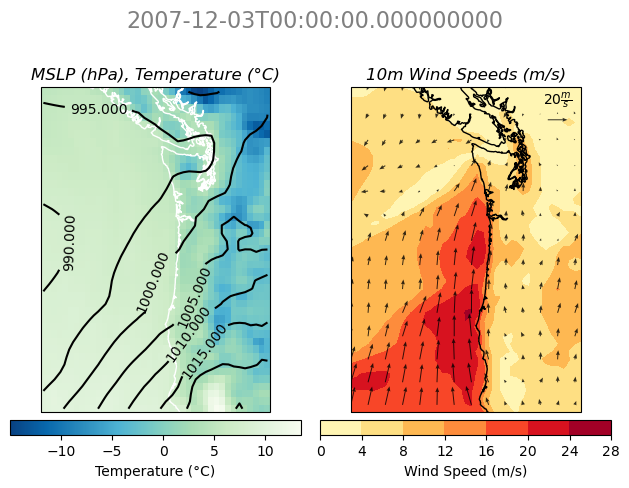

In [361]:
# set time index
t_ind = 48

# subset 10m winds for specified time
u10 = ds.u10.isel(time=t_ind).values
v10 = ds.v10.isel(time=t_ind).values

# set up grid graphs will go on
gs=gridspec.GridSpec(nrows=1,ncols=2)
fig = plt.figure()
ax1=fig.add_subplot(gs[0,0], projection=ccrs.Mercator()) 
ax2=fig.add_subplot(gs[0,1], projection=ccrs.Mercator())
fig.suptitle(ds.time[t_ind].values, fontsize=16, y=1.01, color='grey')

# plot mslp and temperature on subplot 1
cs1 = ax1.pcolormesh(ds.longitude, ds.latitude, ds.t2m[0]-273.15, cmap=plt.cm.GnBu_r, shading='auto', transform=ccrs.PlateCarree())
mslp = ax1.contour(ds.longitude, ds.latitude, ds.msl.isel(time=t_ind)/100, colors='k', transform=ccrs.PlateCarree())
plt.clabel(mslp)
s=3
x,y = np.meshgrid(ds.longitude, ds.latitude)
ax1.coastlines(color='w')
fig.colorbar(cs1, label='Temperature (°C)', orientation="horizontal", pad=0.02, ax=ax1)
ax1.set_title('MSLP (hPa), Temperature (°C)', style='italic')

# plot wspd contours and barbs on subplot 2
cs2 = ax2.contourf(ds.longitude, ds.latitude, ds.wspd.isel(time=t_ind), cmap=plt.cm.YlOrRd, transform=ccrs.PlateCarree())
s=3
x,y = np.meshgrid(ds.longitude, ds.latitude)
q = ax2.quiver(x[::s,::s], y[::s,::s], u10[::s,::s], v10[::s,::s], headwidth=4, alpha=0.8, transform=ccrs.PlateCarree())
qk = ax2.quiverkey(q, 0.9, 0.9, 20, r'$20 \frac{m}{s}$')
ax2.coastlines(color='k')
fig.colorbar(cs2, label='Wind Speed (m/s)', orientation="horizontal", pad=0.02, ax=ax2)
ax2.set_title('10m Wind Speeds (m/s)', style='italic')

gs.tight_layout(fig)

### It's apparent from these plots that winds were ripping up the coast parallel to the shoreline when they were near their strongest. The lack of terrain over water is good for winds.
The winds were even stronger 100 meters above the surface (plotted blow):

Text(0.5, 1.0, 'Wind Speeds (m/s)')

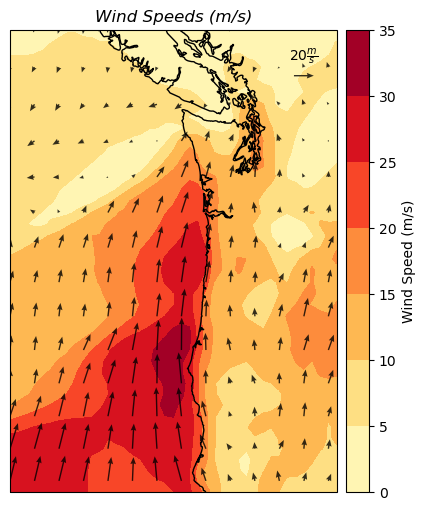

In [365]:
t_ind = 48

# subset 100m winds for specified time
fig = plt.figure(figsize=(6,6))
ax=fig.add_subplot(projection=ccrs.Mercator()) 
u100 = ds.u100.isel(time=t_ind).values
v100 = ds.v100.isel(time=t_ind).values
ds['wspd_100'] = np.sqrt(ds.u100**2 + ds.v100**2) * units.meters/units.seconds

cs = ax.contourf(ds.longitude, ds.latitude, ds.wspd_100.isel(time=t_ind), cmap=plt.cm.YlOrRd, transform=ccrs.PlateCarree())
s=3
x,y = np.meshgrid(ds.longitude, ds.latitude)
q = ax.quiver(x[::s,::s], y[::s,::s], u100[::s,::s], v100[::s,::s], headwidth=4, alpha=0.8, transform=ccrs.PlateCarree())
qk = ax.quiverkey(q, 0.9, 0.9, 20, r'$20 \frac{m}{s}$')
ax.coastlines(color='k')
fig.colorbar(cs, label='Wind Speed (m/s)', pad=0.02, ax=ax)
ax.set_title('Wind Speeds (m/s)', style='italic')


Let's look at some satellite images to get a better idea of the synoptic situation (courtesy of the University of Washington):

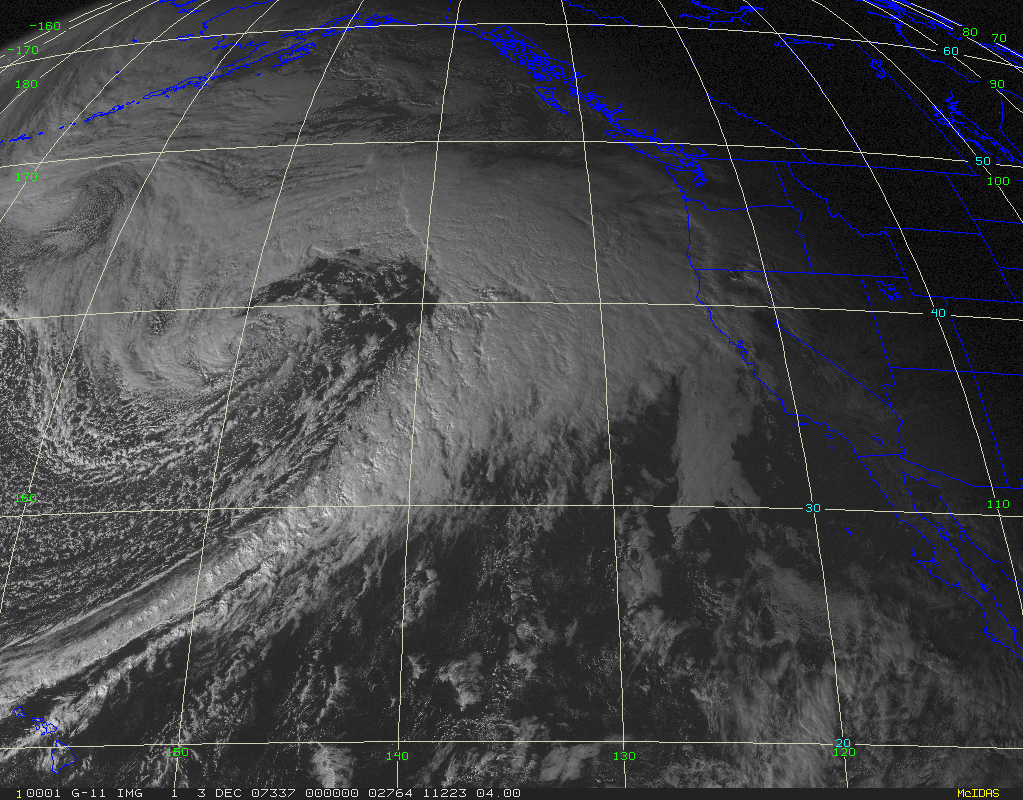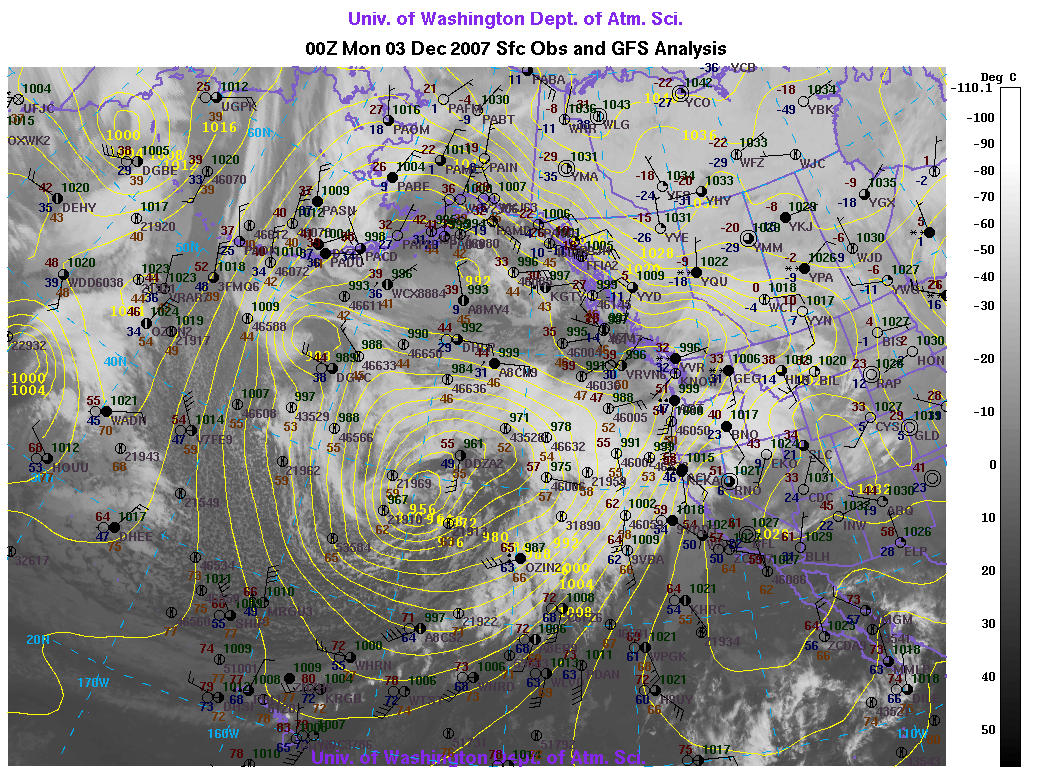

### There's a deep low out in the Pacific Ocean influencing the coastal weather. 
The Great Coastal Gale of 2007 resulted in widespread flooding. Let's take a look at the rain rate:

Maximum large-scale rain rate: 3.2122135162353516 gram / meter ** 2 / second . Occurs at 2007-12-03T11:00:00.000000000 , at lat/lon:  48.75 , -124.5


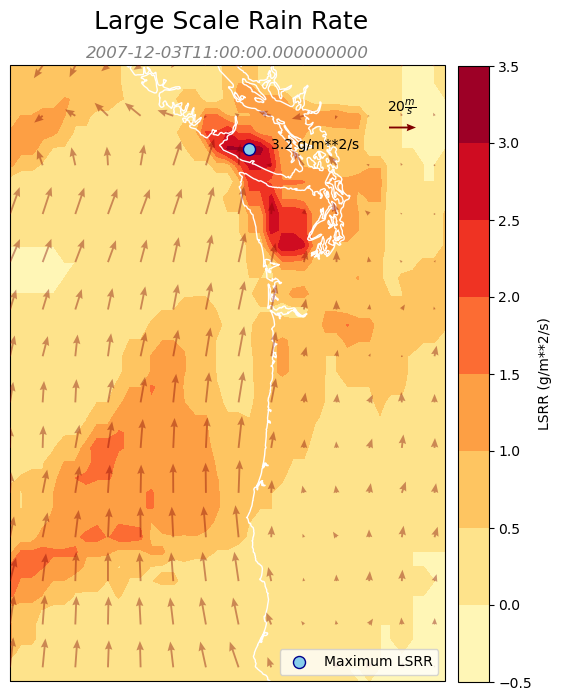

In [298]:
# calculate the large scale rain rate
max_lsrr = ds.lsrr.max().values

# where did this happen?
lsrr_where = ds.where(ds.lsrr==max_lsrr, drop=True)
l_time, l_lat, l_lon = lsrr_where.time[0].values, lsrr_where.latitude[0].values, lsrr_where.longitude[0].values


# let's put some units on using metpy: 
max_lsrr = max_lsrr * units.kilogram/units.meter/units.meter/units.second
max_lsrr = max_lsrr.to(units.gram/units.meter/units.meter/units.second)

print('Maximum large-scale rain rate:', max_lsrr, '. Occurs at', l_time, ', at lat/lon: ' ,l_lat, ',', l_lon)

# plot the large scale rain rate:
t_ind = 59
fig = plt.figure(figsize=(8,8))
ax=fig.add_subplot(projection=ccrs.Mercator()) 
fig.suptitle('Large Scale Rain Rate', fontsize=18, y=0.95)
ax.set_extent([latmin, latmax, lonmin, lonmax], crs=ccrs.PlateCarree())
ax.coastlines(color='white', zorder=1)
ax.set_title(ds.time[t_ind].values, color='grey', style='italic')
ax.scatter(l_lon, l_lat, marker='.', c='skyblue', s=300, label='Maximum LSRR', edgecolors='darkblue', zorder=2, transform=ccrs.PlateCarree())
ax.annotate('3.2 g/m**2/s', (l_lon+0.5, l_lat), transform=ccrs.PlateCarree())
ax.legend(loc=4)
# subset 10m winds for specified time
u10 = ds.u10.isel(time=t_ind).values
v10 = ds.v10.isel(time=t_ind).values
q = ax.quiver(x[::s,::s], y[::s,::s], u10[::s,::s], v10[::s,::s], transform=ccrs.PlateCarree(), headwidth=4, color='maroon', alpha=0.4, zorder=3)
qk = ax.quiverkey(q, 0.9, 0.9, 20, r'$20 \frac{m}{s}$', color='maroon', alpha=1)

cs = ax.contourf(ds.longitude, ds.latitude, ds.lsrr.isel(time=t_ind)*1000, cmap=plt.cm.YlOrRd, transform=ccrs.PlateCarree())
fig.colorbar(cs, label='LSRR (g/m**2/s)', pad=0.02, ax=ax)


### This plot shows particularly well the effect that terrain has on rain. The highest large-scale rain rates here occur on the windward sides of mountains.
Large amounts of rain in the mountains can fill rivers such that there is flooding much further downstream. On December third there had already been two days of storms, so the rivers would have been very high. Melting snowpack from warm air masses also led to rising water. Of the 38 rivers that flooded in this storm, 5 experienced record-breaking levels of flooding, and the Chehalis river had flooding so extreme that half the town was destroyed.<br>
Onshore winds can increase flooding as well, kicking up waves and sending them onto land. Regrettably I cannot plot the wave heights for this storm, because it knocked out 5 observation buoys, leaving large data holes right where we would like to look.
### How much rain fell overall?

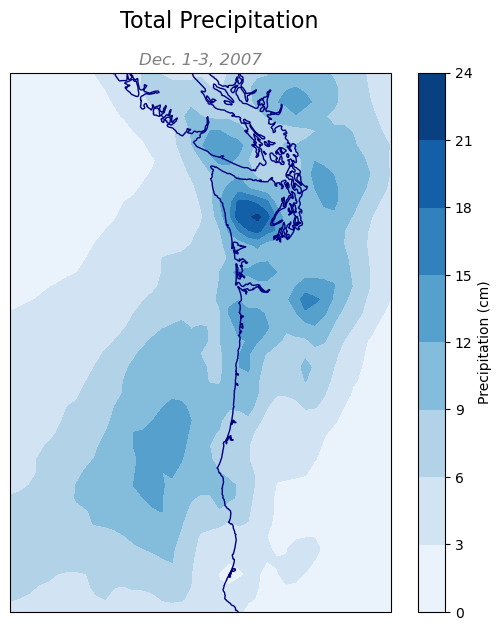

In [328]:
# sum up fallen water over span of the three days
total_rain = ds.tp.sum('time')

#plot total precip
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection = ccrs.Mercator())
fig.suptitle('Total Precipitation', fontsize=16, y=0.97)
ax.set_title('Dec. 1-3, 2007', color='grey', style='italic')
cs = ax.contourf(ds.longitude, ds.latitude, total_rain*100, cmap=plt.cm.Blues, transform=ccrs.PlateCarree())
ax.coastlines(color='navy')
plt.colorbar(cs, label='Precipitation (cm)')

### That's a LOT of precipitation!

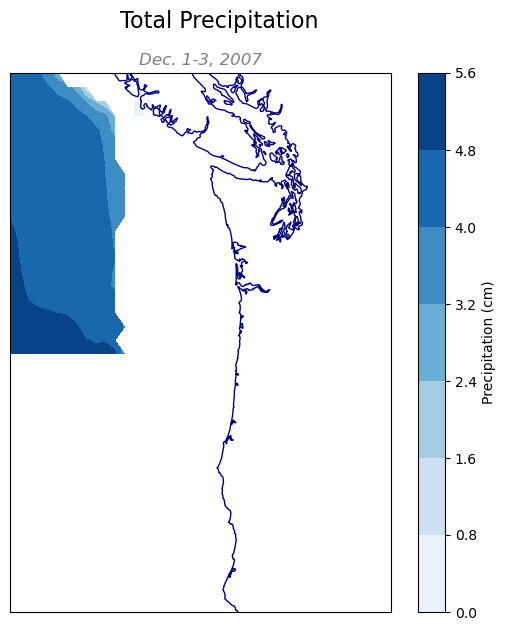

In [327]:
#plot total swh
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection = ccrs.Mercator())
fig.suptitle('Total Precipitation', fontsize=16, y=0.97)
ax.set_title('Dec. 1-3, 2007', color='grey', style='italic')
cs = ax.contourf(ds.longitude, ds.latitude, ds.hmax.isel(time=0), cmap=plt.cm.Blues, transform=ccrs.PlateCarree())
ax.coastlines(color='navy')
plt.colorbar(cs, label='Precipitation (cm)')

In [269]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection = ccrs.Mercator())
# cs = ax.pcolormesh(ds.longitude, ds.latitude, ds.t2m[0]-273.15, cmap=plt.cm.Blues_, shading='auto', transform=ccrs.PlateCarree())
# ax.coastlines(color='w')
# plt.colorbar(cs, label='Temperature (°C)')
# ax.set_title(ds.time[0].values)